# $X$ Gate robust to $Z$ using only $X$ control

This file contains an example use case of the project. The setting here is that we have a qubit (quantum bit) with one control generator: the Pauli $X$ matrix. The goal is to find a control sequence implementing an X gate that is robust to first order for Pauli $Z$ variations in the generator.

The interface with the code is not well developed, but this example demonstrates roughly how I picture the code to be used; as expected use cases can vary heavily, the idea is to provide various tools to make it easy to construct control problems.

In [1]:
# first, add the project the path
import sys
sys.path.append('../')

# functions from outside the project that we'll need
from math import pi
from numpy import zeros,real
from numpy.random import rand

# Define the control system

First, define the control system, which has 0 drift generator, and one control generator given by $-i\pi X$.

Afterwards, define the decoupling system, which is a system derived from the base system that also computes the first order robustness term for a variation $-i\pi Z$ in the generator.

In [2]:
import hamiltonians as h # a file containing Pauli matrices
from control_system import control_system # the control_system object

drift_generator = zeros((2,2)) # zero generator
control_generator = -1j*pi*h.pauliX() # pauli X control generator
x_sys = control_system(drift_generator, control_generator) # create control_system instance

# Define the derived decoupling system
x_sys_dec_z = x_sys.decoupling_system(-1j*pi*h.pauliZ())

# Set parameters of search
The parameters we require:
1. Number of time steps, $N$
2. Length of each time step, $dt$
3. Target gate $U_{target}$
4. Bounds on the absolute value of the control amplitudes and tolerance
5. Bounds on the rate of change of the control amplitudes and tolerance

Note that, aside from number of time steps, the parameters set here are essentially arbitrary, and in practice would be set by the physical system of interest. The number of time steps here was arrived at by running the search on various values, until a value of $N$ was found for which:
1. The objective function can be optimized to the best possible value.
2. Decreasing $N$ by $1$ results in no (currently tested) searches achieving the best possible  objective value.
Hence, the above two points suggest that the current value of $N$ is roughly the shortest possible value for which a control sequence with the desired properties exists.

In [3]:
N = 152 # number of time steps
dt = 0.0125 # length of time step
Utarget = h.pauliX() # target gate to implement is pauli X

# Set bounds on the control amplitude and tolerance
power_ub = 1 # upper bound
power_lb = -1 # lower bound
power_tol = 0.05 # tolerance

# bounds on the control amplitude rate of change
change_b = 0.025 # bound on rate
change_tol = 0.005 # tolerance

# set a variable storing the shape of a control sequence array
# ctrl_shape = (# time steps, # control amplitudes)
ctrl_shape = (N, 1)

# Define the objective

Next, define the objective. Components of the objective are:
1. Optimizing the final gate to be $X$.
2. Optimizing terms in the derived decoupling system quantifying robustness to $Z$ to be $0$
3. Constraints on amplitude of the control sequence implemented as penalties.

Note that objectives are currently assumed to take in a 2d array of shape ctrl_shape, and output a tuple (val, vald), where val is the value of the objective at the input, and vald is the jacobian of the objective at the input.

In [4]:
# import functions from the package to help
from evolve_system import evolve_system # computes system propagator and derivatives
from objective_functions import grape_objective, zero_block_objective # for gate and decoupling optimization
from constraint_functions import mono_objective as penalty # for constraints as penalties

# Construct an objective using ingredients provided by project
def obj(amps):
    prop = evolve_system(x_sys_dec_z, amps, dt, deriv = 1) #evolve the system

    Ufinal = prop[0][0:2,0:2] # extract final unitary
    Uderiv = prop[1][:,:,0:2,0:2] # extract jacobian of final unitary
    
    # target gate objective
    g,gp = grape_objective(Utarget, (Ufinal,Uderiv), deriv = 1)
    
    # first order robustness objective
    dec,decp= zero_block_objective(prop, 2, 0,1, deriv = 1)

    # penalty and derivatives of pulse shape
    shape,shaped = penalty(amps, power_lb, power_ub, power_tol, change_b, change_tol, deriv = 1)

    # return a weighted combination (to be used in minimization)
    return real(-g + dec+shape/20),real(-gp + decp+ shaped/20)

# Run the optimization

Currently, the optimizer used is the implementation of BFGS available in SciPy.

Note:
1. Best possible value of this objective is $-4$.
2. With current parameters, often finds a solution within $10^{-10}$ of $-4$, but as the number of time steps seems to be at the edge of what is possible, it will not always find a good solution, and will need to be run again.

In [6]:
# import the optimizer
from pulse_finders import find_pulse_bfgs

update_rate = 150 # rate of printed updates
initial_guess = rand(*ctrl_shape) # random initial guess

results = find_pulse_bfgs(obj, ctrl_shape, initial_guess, update_rate) # run optimization

Optimizing pulse...
Value at evaluation 150: 21.319912603334338
Value at evaluation 300: -3.9988544019044157
Value at evaluation 450: -3.999993515262457
Optimization terminated successfully.
         Current function value: -4.000000
         Iterations: 413
         Function evaluations: 521
         Gradient evaluations: 521
Total time taken: 12.842772960662842


In [7]:
amps = results.x # get the control sequence from the results object
4+results.fun # check the value achieved

-3.552713678800501e-15

# Plotting
Now that a sequence numerically satisfying the desired criteria has been found, we can examine its properties. Currently, the plotting features in this project are rudimentary, but some simple plots demonstrate that the optimization is functioning as desired.

## Plot the control sequence itself
First, just plot the amplitudes as a function of time.

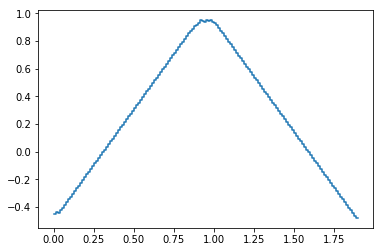

In [9]:
import control_plotting as cplot # import the plotting file

cplot.step_plot(amps, dt)

The sequence has an interesting shape. The smoothness constraints ensure that the amplitude can't change much between time steps. Typically, when performing these searches:
1. If, given all of the other constraints, the number of time steps is only just long enough for the objective to achieve the best possible value, the control sequence will tend to have nice structure.
2. If the number of time steps is well beyond the minimum time required to achieve the objective function's optimal value, then it will tend to not have much structure. 

### Robustness to variations in $X$ 

Next, plot the fidelity of the final gate as a function of $\epsilon$ with respect to variations in the generator of the form $\epsilon(-i \pi Z)$.

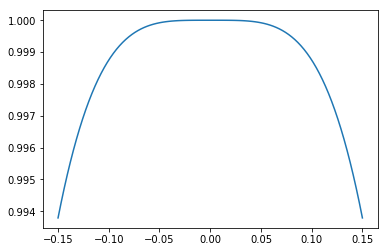

In [10]:
# set the range of values of epsilon to check
from numpy import linspace

bound = 0.15
steps = 100
eps = linspace(-bound, bound, steps)
generator_variation = -1j*pi*h.pauliZ()

cplot.target_robustness_1d(x_sys, amps,dt, Utarget, generator_variation, eps)

As the above plot shows, a high fidelity is achieved for a range of values of $\epsilon$, and in particular, the fidelity function is flat at $\epsilon = 0$, as desired.